# Analyse Exploratoire du Dataset Chicago Taxi Trips (Version Améliorée V3)

Ce notebook vise à explorer en profondeur un **échantillon filtré et nettoyé** du dataset Chicago Taxi Trips, directement depuis BigQuery. Nous allons :
- Charger et nettoyer les données via SQL BigQuery
- Effectuer des vérifications de qualité : valeurs manquantes, incohérences, nulles/faibles, outliers (IQR)
- Explorer la distribution des variables clés et leurs transformations (log, clipping)
- Analyser les interactions entre variables numériques et catégorielles
- Visualiser les localisations GPS des pickups/dropoffs (si disponibles)
- Tirer des conclusions précises pour le prétraitement et la modélisation

In [1]:
# Imports principaux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

# Configuration d'affichage
%matplotlib inline
sns.set(style="whitegrid", context="talk")
base_palette = sns.color_palette("viridis", 8)
sns.set_palette(base_palette)
warnings.filterwarnings("ignore")

In [2]:
# Connexion BigQuery + Chargement Dataset (semaine entière de janvier 2023, filtrée proprement)
from google.cloud import bigquery
from pandas_gbq import read_gbq

project_id = "avisia-certification-ml-yde"  # ← à adapter selon ton projet GCP

query = """
SELECT
  unique_key, taxi_id, trip_start_timestamp, trip_end_timestamp,
  trip_seconds, trip_miles, fare, tips, tolls, extras, trip_total,
  payment_type, company,
  pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, pickup_community_area, dropoff_community_area
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  trip_start_timestamp BETWEEN '2023-01-01' AND '2023-01-07'
  AND trip_seconds > 0
  AND trip_miles > 0
  AND fare > 0
LIMIT 200000
"""

print("📥 Chargement des données depuis BigQuery...")
df = read_gbq(query, project_id=project_id, dialect="standard")
print(f"✅ {len(df)} lignes chargées.")

# Nettoyage noms de colonnes
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

📥 Chargement des données depuis BigQuery...
✅ 65774 lignes chargées.


In [3]:
# %% [code]
print("\n🔄 Conversion initiale des types...")

# Conversion des colonnes temporelles
for col in ['trip_start_timestamp', 'trip_end_timestamp']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Colonnes numériques à convertir
cols_numeric = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total']
for col in cols_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Création de colonnes dérivées
df['trip_minutes'] = df['trip_seconds'] / 60
df['average_speed_mph'] = df['trip_miles'] / (df['trip_minutes'] / 60)

print("✅ Conversion terminée.")

# Aperçu
print("\n🔎 Informations générales sur le dataset :")
df.info()

print("\n👁️‍🗨️ Aperçu des premières lignes :")
display(df.head())

print("\n📊 Statistiques descriptives :")
display(df.describe(include='all'))



🔄 Conversion initiale des types...
✅ Conversion terminée.

🔎 Informations générales sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65774 entries, 0 to 65773
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              65774 non-null  object             
 1   taxi_id                 65774 non-null  object             
 2   trip_start_timestamp    65774 non-null  datetime64[us, UTC]
 3   trip_end_timestamp      65774 non-null  datetime64[us, UTC]
 4   trip_seconds            65774 non-null  Int64              
 5   trip_miles              65774 non-null  float64            
 6   fare                    65774 non-null  float64            
 7   tips                    65774 non-null  float64            
 8   tolls                   65774 non-null  float64            
 9   extras                  65774 non-null  float64            
 10  trip

unique_key  \
0  2b3c5200439d51f626b60380809bbbcca766a85b   
1  0fca59218b11688279d795c03c4d16f851f13fa0   
2  1e539d6e7501164c6b76b761c3152c235e206d59   
3  c22902fdf0548a8d12ce49015763fcb9330d4080   
4  00adaa1989ce971e02ef7600c06f117e5ff3bd29   

                                             taxi_id  \
0  8c76eb82f069c0731a0049cb78898f02cc5ac6990244c9...   
1  e2c349c7cbb608d552aa0b5814031943f13641ef9e50d8...   
2  4ab7a7510c1ebcc9b2e3eaa7bdd6508dbea34da7986aca...   
3  1bb875f74db6b3d8bcab27f6784218036ec738c201e533...   
4  91a036e3de3c1f459f2664801ea9388870751ae14e196e...   

       trip_start_timestamp        trip_end_timestamp  trip_seconds  \
0 2023-01-01 00:00:00+00:00 2023-01-01 00:15:00+00:00           844   
1 2023-01-01 00:00:00+00:00 2023-01-01 00:15:00+00:00          1037   
2 2023-01-01 00:00:00+00:00 2023-01-01 00:15:00+00:00          1341   
3 2023-01-01 00:00:00+00:00 2023-01-01 00:00:00+00:00             6   
4 2023-01-01 20:45:00+00:00 2023-01-01 21:00:00+00:00           711   

   trip_miles   fare  tips  tolls  extras  ...  payment_type  \
0        3.84  16.14  4.03    0.0     0.0  ...        Mobile   
1        4.82  15.75  3.25    0.0     0.0  ...   Credit Card   
2       16.63  41.50  5.00    0.0     6.0  ...   Credit Card   
3        0.07   3.25  0.00    0.0     0.0  ...          Cash   
4        8.02  21.50  7.00    0.0     6.0  ...   Credit Card   

                        company pickup_latitude  pickup_longitude  \
0                      Sun Taxi       41.901207        -87.676356   
1  Taxicab Insurance Agency Llc       41.944227        -87.655998   
2                      Sun Taxi       41.980264        -87.913625   
3                     Flash Cab             NaN               NaN   
4                  City Service             NaN               NaN   

   dropoff_latitude  dropoff_longitude  pickup_community_area  \
0         41.899602         -87.633308                     24   
1         41.878866         -87.625192                      6   
2         41.899602         -87.633308                     76   
3               NaN                NaN                   <NA>   
4               NaN                NaN                   <NA>   

   dropoff_community_area  trip_minutes  average_speed_mph  
0                       8     14.066667          16.379147  
1                      32     17.283333          16.732883  
2                       8         22.35          44.644295  
3                    <NA>           0.1               42.0  
4                    <NA>         11.85          40.607595  

[5 rows x 21 columns]


📊 Statistiques descriptives :


unique_key  \
count                                      65774   
unique                                     65774   
top     93f61e9c31c96bc5376ceb336adcbaa1159cd721   
freq                                           1   
mean                                         NaN   
min                                          NaN   
25%                                          NaN   
50%                                          NaN   
75%                                          NaN   
max                                          NaN   
std                                          NaN   

                                                  taxi_id  \
count                                               65774   
unique                                               2047   
top     d40dae7ea46d61abca67eb53b157fe9cf0b485cca6dce1...   
freq                                                  160   
mean                                                  NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   
std                                                   NaN   

                    trip_start_timestamp                trip_end_timestamp  \
count                              65774                             65774   
unique                               NaN                               NaN   
top                                  NaN                               NaN   
freq                                 NaN                               NaN   
mean    2023-01-04 06:06:28.370784+00:00  2023-01-04 06:25:42.919694+00:00   
min            2023-01-01 00:00:00+00:00         2023-01-01 00:00:00+00:00   
25%            2023-01-02 19:30:00+00:00         2023-01-02 19:45:00+00:00   
50%            2023-01-04 10:15:00+00:00         2023-01-04 10:30:00+00:00   
75%            2023-01-05 16:15:00+00:00         2023-01-05 16:30:00+00:00   
max            2023-01-07 00:00:00+00:00         2023-01-07 13:00:00+00:00   
std                                  NaN                               NaN   

        trip_seconds    trip_miles          fare          tips         tolls  \
count        65774.0  65774.000000  65774.000000  65774.000000  65774.000000   
unique          <NA>           NaN           NaN           NaN           NaN   
top             <NA>           NaN           NaN           NaN           NaN   
freq            <NA>           NaN           NaN           NaN           NaN   
mean     1156.074771      7.336365     22.662424      2.448205      0.011765   
min              1.0      0.010000      0.010000      0.000000      0.000000   
25%            502.0      1.300000      9.000000      0.000000      0.000000   
50%            959.0      4.510000     18.475000      0.000000      0.000000   
75%           1544.0     11.980000     33.250000      3.240000      0.000000   
max          80066.0    899.500000    513.500000     87.000000     30.500000   
std      1739.985511     10.560989     17.139451      3.930707      0.365478   

              extras  ...  payment_type    company pickup_latitude  \
count   65774.000000  ...         65774      65774    61725.000000   
unique           NaN  ...             7         27             NaN   
top              NaN  ...   Credit Card  Flash Cab             NaN   
freq             NaN  ...         22069      13816             NaN   
mean        2.111024  ...           NaN        NaN       41.900387   
min         0.000000  ...           NaN        NaN       41.660136   
25%         0.000000  ...           NaN        NaN       41.878866   
50%         0.000000  ...           NaN        NaN       41.899602   
75%         4.000000  ...           NaN        NaN       41.968069   
max       132.870000  ...           NaN        NaN       42.016046   
std         


📉 Pourcentage de valeurs manquantes (> 0%) :


dropoff_community_area    10.253292
dropoff_latitude           9.955301
dropoff_longitude          9.955301
pickup_latitude            6.155928
pickup_longitude           6.155928
pickup_community_area      6.155928
dtype: float64


🧱 Matrice des valeurs manquantes :


<Figure size 1600x800 with 0 Axes>

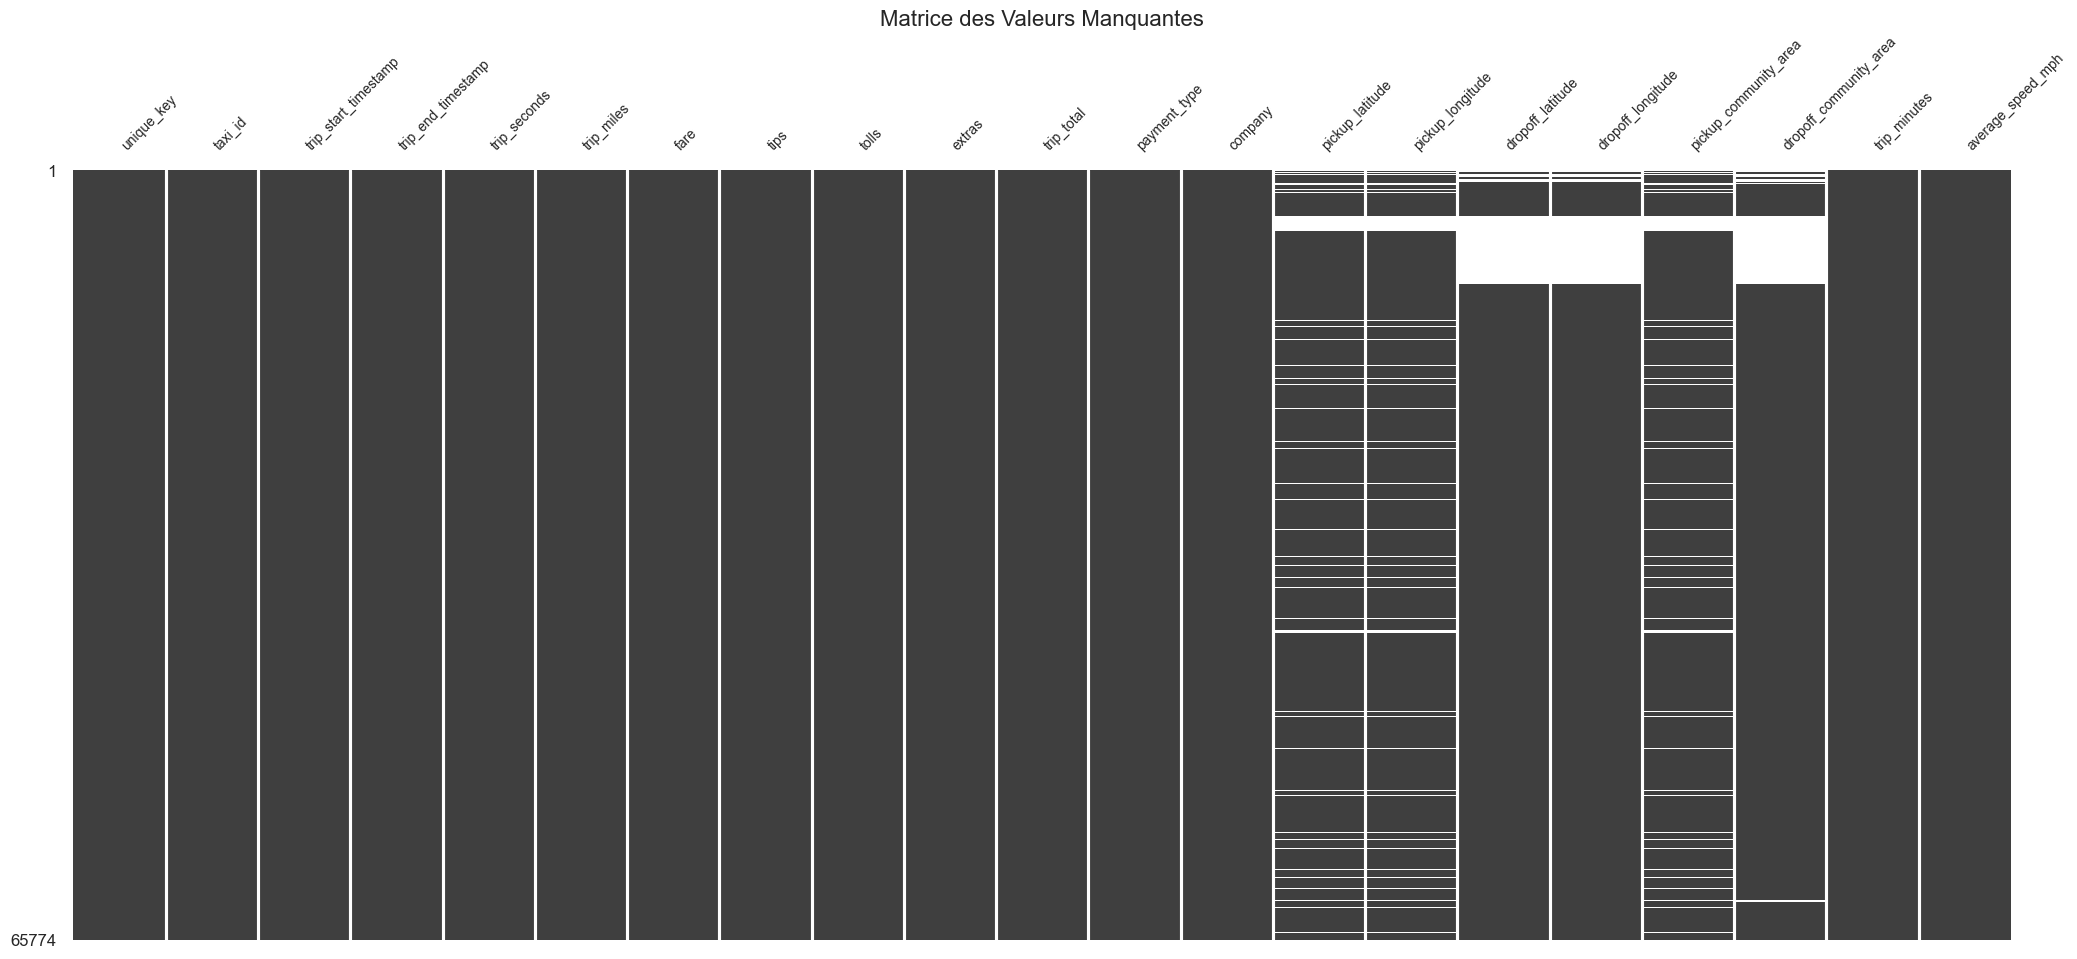


📊 Visualisation des pourcentages de valeurs manquantes :


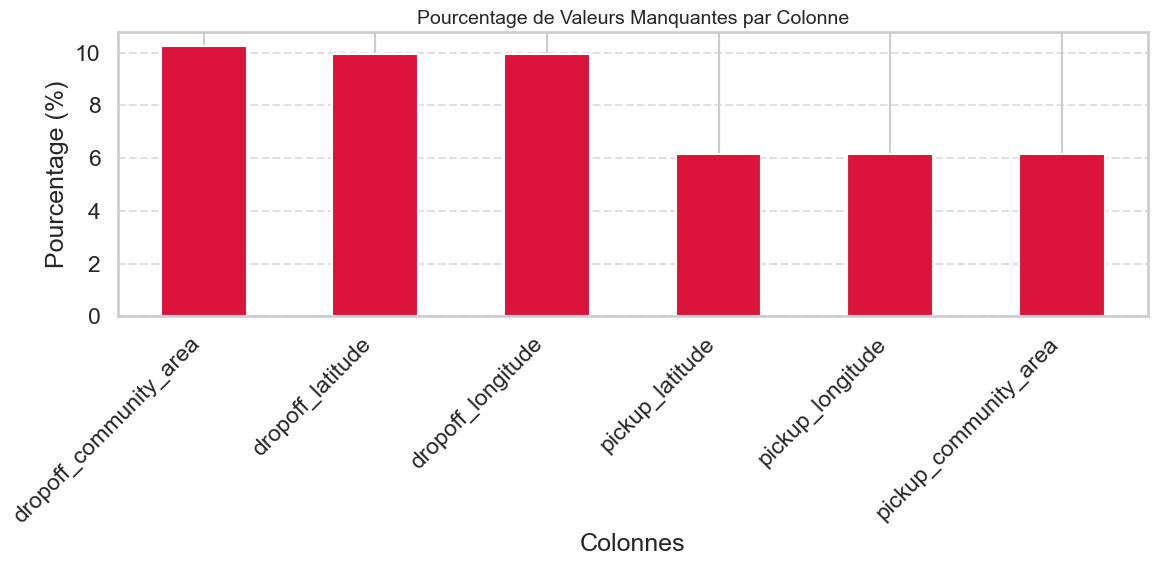

In [4]:
# %% [code]
# Calcul des pourcentages de valeurs manquantes
missing_pct = df.isnull().sum() / len(df) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

print("\n📉 Pourcentage de valeurs manquantes (> 0%) :")
display(missing_pct)

# Visualisation avec missingno
print("\n🧱 Matrice des valeurs manquantes :")
plt.figure(figsize=(16, 8))
msno.matrix(df.iloc[:, :40], sparkline=False, fontsize=10)
plt.title("Matrice des Valeurs Manquantes", fontsize=16)
plt.show()

# Barplot du pourcentage de valeurs manquantes
print("\n📊 Visualisation des pourcentages de valeurs manquantes :")
plt.figure(figsize=(12, 6))
missing_pct.plot(kind='bar', color='crimson')
plt.title("Pourcentage de Valeurs Manquantes par Colonne", fontsize=14)
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# %% [code]
# Création de la colonne 'trip_minutes' si absente
if 'trip_seconds' in df.columns and 'trip_minutes' not in df.columns:
    df['trip_minutes'] = df['trip_seconds'] / 60

# --- Courses avec durée nulle ou négative ---
if 'trip_minutes' in df.columns:
    zero_duration_trips = df[df['trip_minutes'] <= 0]
    print(f"\n⏱️ Nombre de courses avec durée <= 0 min : {len(zero_duration_trips)}")
    if not zero_duration_trips.empty:
        print("Statistiques (médianes) sur ces courses :")
        display(zero_duration_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
        print("\nTypes de paiement fréquents (durée ≤ 0) :")
        display(zero_duration_trips['payment_type'].value_counts().head())

# --- Courses avec distance nulle ou négative ---
if 'trip_miles' in df.columns:
    zero_distance_trips = df[df['trip_miles'] <= 0]
    print(f"\n🛣️ Nombre de courses avec distance <= 0 mile : {len(zero_distance_trips)}")
    if not zero_distance_trips.empty:
        print("Statistiques (médianes) :")
        display(zero_distance_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
        print("\nTypes de paiement fréquents (distance ≤ 0) :")
        display(zero_distance_trips['payment_type'].value_counts().head())

# --- Courses avec tarif nul ou négatif ---
if 'fare' in df.columns:
    zero_fare_trips = df[df['fare'] <= 0]
    print(f"\n💵 Nombre de courses avec tarif <= 0 $ : {len(zero_fare_trips)}")
    if not zero_fare_trips.empty:
        print("Statistiques (médianes) :")
        display(zero_fare_trips[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())
        print("\nTypes de paiement fréquents (fare ≤ 0) :")
        display(zero_fare_trips['payment_type'].value_counts().head())

        # Vérifier les cas où le trip_total > 0 malgré fare = 0
        pct_total_pos = 100 * (zero_fare_trips['trip_total'] > 0).mean()
        print(f"📌 % de ces courses où 'trip_total' > 0 : {pct_total_pos:.2f}%")

# --- Courses avec distance > 0 mais très faible ---
very_low_distance = df[(df['trip_miles'] > 0) & (df['trip_miles'] < 0.1)]
print(f"\n📏 Nombre de courses avec distance très faible (0 < miles < 0.1) : {len(very_low_distance)}")
if not very_low_distance.empty:
    print("Statistiques (médianes) :")
    display(very_low_distance[['trip_minutes', 'trip_miles', 'fare', 'trip_total']].median())



⏱️ Nombre de courses avec durée <= 0 min : 0

🛣️ Nombre de courses avec distance <= 0 mile : 0

💵 Nombre de courses avec tarif <= 0 $ : 0

📏 Nombre de courses avec distance très faible (0 < miles < 0.1) : 487
Statistiques (médianes) :


trip_minutes    0.333333
trip_miles          0.03
fare                3.25
trip_total          3.25
dtype: Float64

In [6]:
# Vérifie que 'trip_start_timestamp' est présent
if 'trip_start_timestamp' in df.columns:
    print("\n⏳ Création des features temporelles à partir de 'trip_start_timestamp'...")

    df['start_hour'] = df['trip_start_timestamp'].dt.hour
    df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek  # Lundi=0, Dimanche=6
    df['day_name'] = df['trip_start_timestamp'].dt.day_name()
    df['month'] = df['trip_start_timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    print("✅ Colonnes créées : start_hour, day_of_week, day_name, month, is_weekend")
    display(df[['trip_start_timestamp', 'start_hour', 'day_of_week', 'day_name', 'month', 'is_weekend']].head())
else:
    print("⚠️ Colonne 'trip_start_timestamp' manquante, impossible de créer les features temporelles.")




⏳ Création des features temporelles à partir de 'trip_start_timestamp'...
✅ Colonnes créées : start_hour, day_of_week, day_name, month, is_weekend


trip_start_timestamp  start_hour  day_of_week day_name  month  \
0 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
1 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
2 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
3 2023-01-01 00:00:00+00:00           0            6   Sunday      1   
4 2023-01-01 20:45:00+00:00          20            6   Sunday      1   

   is_weekend  
0           1  
1           1  
2           1  
3           1  
4           1


🚕 Calcul de la vitesse moyenne en mph...
✅ Colonne 'average_speed_mph' ajoutée au DataFrame.
count    65774.000000
mean        26.763383
std        409.254571
min          0.002593
25%         10.369680
50%         17.237642
75%         30.323424
max      65808.000000
Name: average_speed_mph, dtype: float64


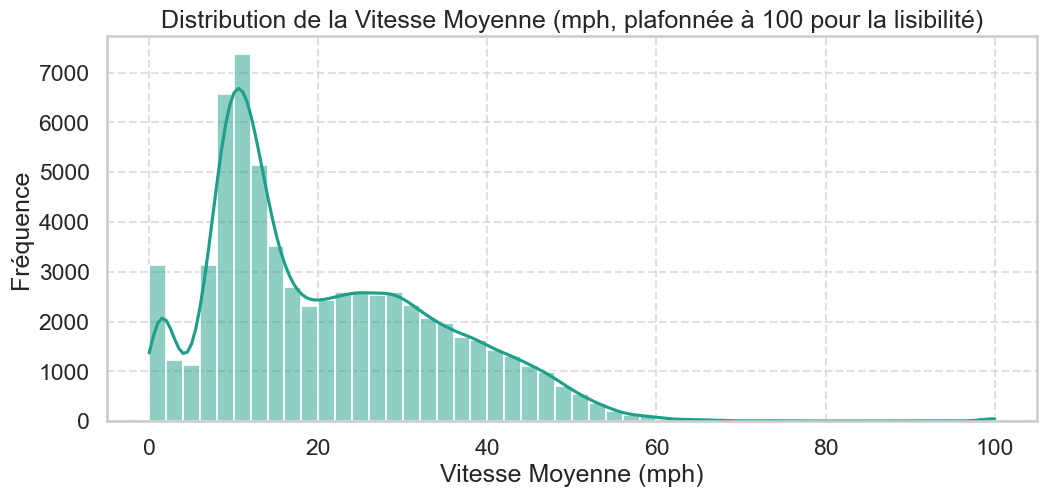

In [7]:
# %% [code]
# Calcul de la vitesse moyenne en miles par heure
if 'trip_miles' in df.columns and 'trip_minutes' in df.columns:
    print("\n🚕 Calcul de la vitesse moyenne en mph...")

    # Éviter les divisions par 0
    df['average_speed_mph'] = df.apply(
        lambda row: row['trip_miles'] / (row['trip_minutes'] / 60)
        if row['trip_minutes'] > 0 else 0,
        axis=1
    )

    print("✅ Colonne 'average_speed_mph' ajoutée au DataFrame.")
    print(df['average_speed_mph'].describe())

    # Visualisation de la distribution
    plt.figure(figsize=(12, 5))
    sns.histplot(df['average_speed_mph'].clip(upper=100), bins=50, kde=True, color=base_palette[4])
    plt.title("Distribution de la Vitesse Moyenne (mph, plafonnée à 100 pour la lisibilité)")
    plt.xlabel("Vitesse Moyenne (mph)")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("⚠️ Colonnes 'trip_miles' ou 'trip_minutes' manquantes, impossible de calculer la vitesse moyenne.")



📈 Calcul de la vitesse moyenne médiane par heure de début...


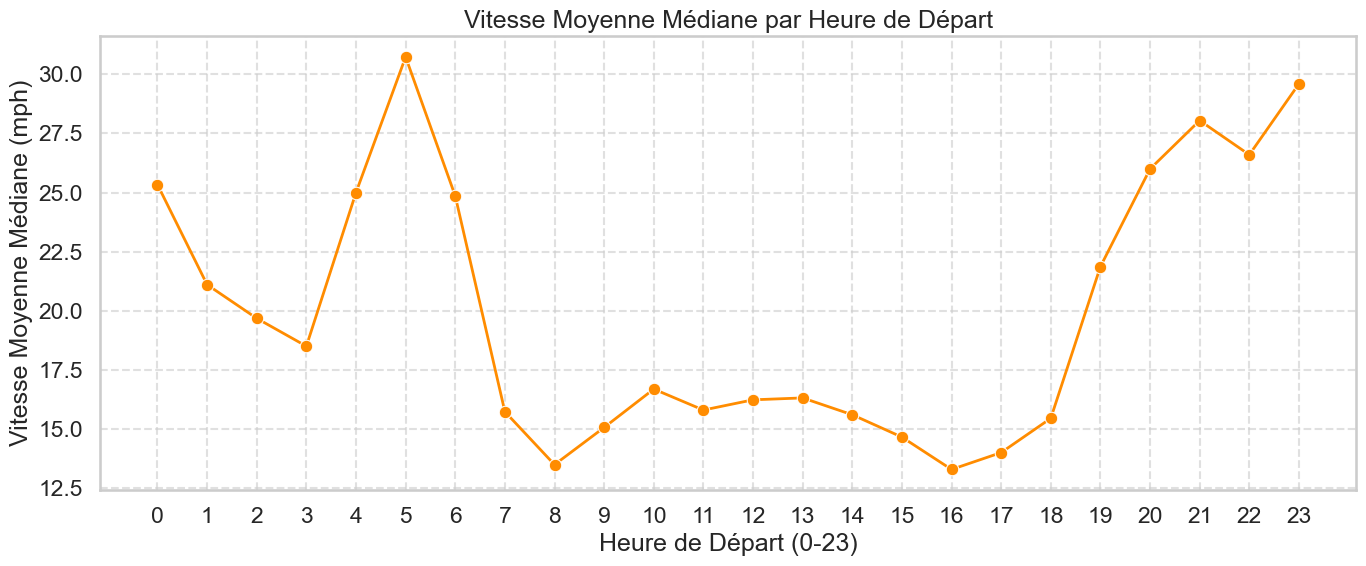

In [8]:
# Analyse temporelle : vitesse moyenne médiane par heure de départ
if 'average_speed_mph' in df.columns and 'start_hour' in df.columns:
    print("\n📈 Calcul de la vitesse moyenne médiane par heure de début...")

    avg_speed_by_hour = df.groupby('start_hour')['average_speed_mph'].median().reset_index()

    plt.figure(figsize=(14, 6))
    sns.lineplot(data=avg_speed_by_hour, x='start_hour', y='average_speed_mph', marker='o',
                 linewidth=2, color='darkorange')
    plt.title("Vitesse Moyenne Médiane par Heure de Départ")
    plt.xlabel("Heure de Départ (0-23)")
    plt.ylabel("Vitesse Moyenne Médiane (mph)")
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Colonnes 'average_speed_mph' ou 'start_hour' manquantes.")

### Visualisation des Localisations (pickup/dropoff)

In [9]:
import folium
from folium.plugins import MarkerCluster

# Centrer la carte sur Chicago
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
pickup_coords = df[['pickup_latitude', 'pickup_longitude']].dropna().sample(500)
marker_cluster = MarkerCluster().add_to(m)

for idx, row in pickup_coords.iterrows():
    folium.CircleMarker(
        location=(row['pickup_latitude'], row['pickup_longitude']),
        radius=2,
        fill=True,
        color='blue',
        fill_opacity=0.4
    ).add_to(marker_cluster)

m

In [10]:
# %% [code]
# !pip install folium --quiet  # À décommenter si folium n'est pas installé

import folium
from folium.plugins import HeatMap

# Centrer la carte sur Chicago
map_center = [41.8781, -87.6298]  # Coordonnées de Chicago
base_map = folium.Map(location=map_center, zoom_start=11)

# Option de filtrage pour éviter surcharge (ex: 10k points)
sampled_pickups = df[['pickup_latitude', 'pickup_longitude']].dropna().sample(n=10000, random_state=42)

# Conversion au format liste de points
heat_data = sampled_pickups.values.tolist()

# Ajout du HeatMap
HeatMap(heat_data, radius=8, blur=10, max_zoom=12).add_to(base_map)

# Affichage
print("🌡️ Carte thermique des points de prise en charge (pickup)")
display(base_map)


🌡️ Carte thermique des points de prise en charge (pickup)


In [11]:
# Carte centrée sur Chicago
dropoff_map = folium.Map(location=map_center, zoom_start=11)

# Filtrage dropoff (évite surcharge sur grand jeu)
sampled_dropoffs = df[['dropoff_latitude', 'dropoff_longitude']].dropna().sample(n=10000, random_state=42)

# Conversion en liste de points
heat_data_dropoff = sampled_dropoffs.values.tolist()

# Ajout du HeatMap
HeatMap(heat_data_dropoff, radius=8, blur=10, max_zoom=12).add_to(dropoff_map)

# Affichage
print("🌡️ Carte thermique des points de dépose (dropoff)")
display(dropoff_map)


🌡️ Carte thermique des points de dépose (dropoff)


In [12]:
import plotly.express as px

# Ajouter une colonne "type" pour différencier pickup et dropoff
pickup_points = sampled_pickups[['pickup_latitude', 'pickup_longitude']].copy()
pickup_points.columns = ['lat', 'lon']
pickup_points['type'] = 'pickup'

dropoff_points = sampled_dropoffs[['dropoff_latitude', 'dropoff_longitude']].copy()
dropoff_points.columns = ['lat', 'lon']
dropoff_points['type'] = 'dropoff'

# Fusionner les deux
map_data = pd.concat([pickup_points, dropoff_points], axis=0).dropna()

# Visualisation interactive
fig = px.scatter_mapbox(
    map_data,
    lat="lat",
    lon="lon",
    color="type",
    zoom=10,
    opacity=0.4,
    title="📍 Position des Pickups vs Dropoffs (échantillon)",
    mapbox_style="carto-positron",
    height=650
)
fig.show()


In [13]:
# %% [code]
import folium
from folium.plugins import MarkerCluster

# Limiter à 1000 lignes pour la performance (peut être ajusté selon RAM)
sample_geo = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].dropna().sample(n=1000, random_state=42)

# Carte centrée sur Chicago
map_center = [41.8781, -87.6298]
m = folium.Map(location=map_center, zoom_start=11, tiles='CartoDB positron')

# Marqueurs pour pickup
pickup_cluster = MarkerCluster(name='Pickup Locations').add_to(m)
for _, row in sample_geo.iterrows():
    folium.CircleMarker(
        location=(row['pickup_latitude'], row['pickup_longitude']),
        radius=3, color='blue', fill=True, fill_opacity=0.5
    ).add_to(pickup_cluster)

# Marqueurs pour dropoff
dropoff_cluster = MarkerCluster(name='Dropoff Locations').add_to(m)
for _, row in sample_geo.iterrows():
    folium.CircleMarker(
        location=(row['dropoff_latitude'], row['dropoff_longitude']),
        radius=3, color='green', fill=True, fill_opacity=0.5
    ).add_to(dropoff_cluster)

# Afficher la carte
folium.LayerControl().add_to(m)
m


In [17]:
# 3. Fonction de clipping IQR
def iqr_clip(series, verbose=True):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)
    upper_bound = Q3 + 1.5 * IQR
    clipped = series.clip(lower=lower_bound, upper=upper_bound)
    if verbose:
        print(f"IQR Clipping → {series.name}: [{lower_bound:.2f}, {upper_bound:.2f}]")
    return clipped

# 4. Clipping IQR sur la distance
if 'trip_miles' in df.columns:
    df['trip_miles_iqr_capped'] = iqr_clip(df['trip_miles'].dropna(), verbose=True)
    print("✅ Colonne 'trip_miles_iqr_capped' créée.")
else:
    print("❌ Colonne 'trip_miles' non trouvée, impossible de créer 'trip_miles_iqr_capped'.")

IQR Clipping → trip_miles: [0.00, 28.00]
✅ Colonne 'trip_miles_iqr_capped' créée.


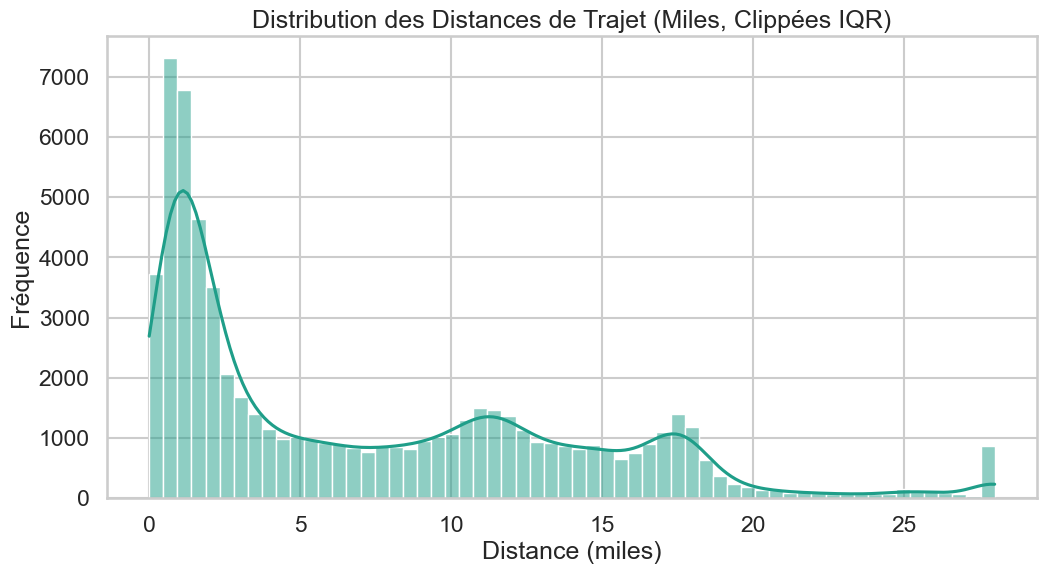

In [18]:
# %% [code]
plt.figure(figsize=(12, 6))
if 'trip_miles_iqr_capped' in df.columns:
    sns.histplot(df['trip_miles_iqr_capped'], bins=60, kde=True, color=base_palette[4])
    plt.title("Distribution des Distances de Trajet (Miles, Clippées IQR)")
    plt.xlabel("Distance (miles)")
    plt.ylabel("Fréquence")
else:
    print("Colonne 'trip_miles_iqr_capped' non disponible.")
plt.show()


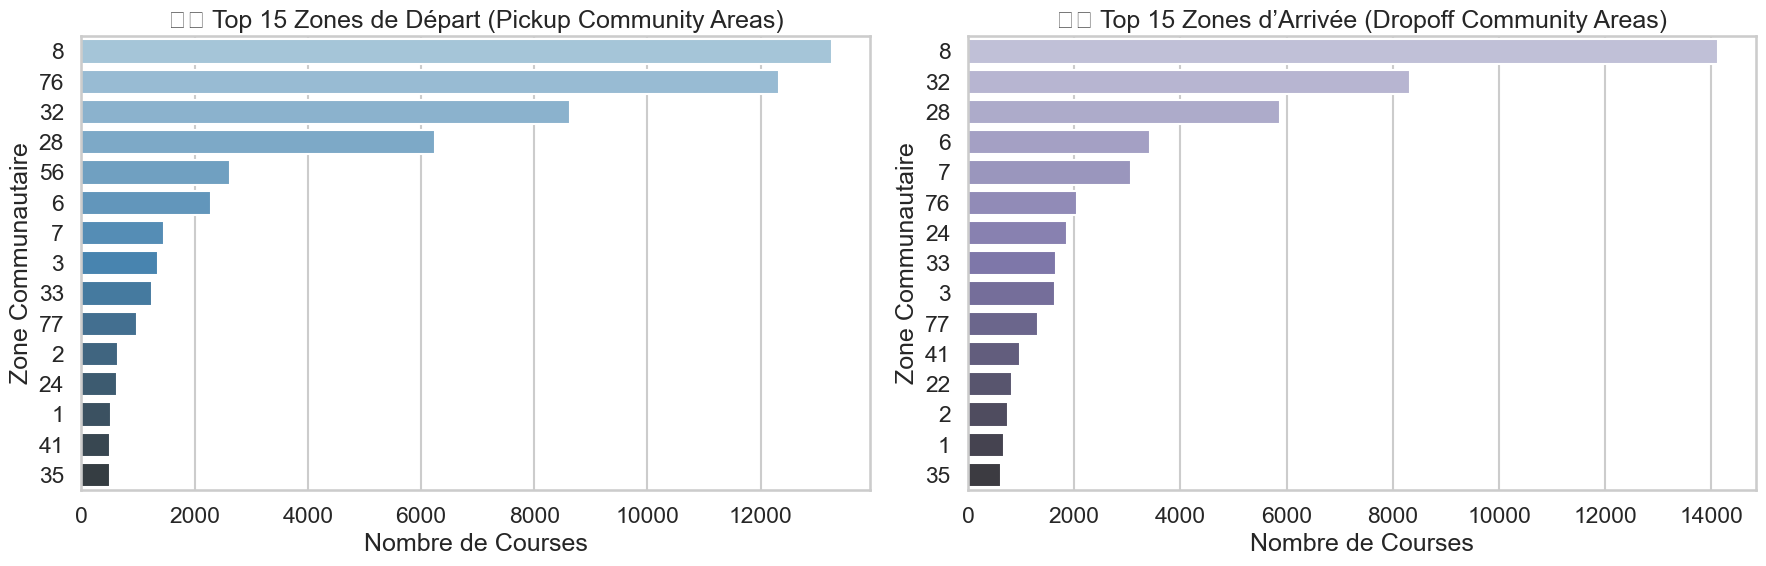

In [15]:
# %% [code]
# Vérification existence colonnes
if 'pickup_community_area' in df.columns and 'dropoff_community_area' in df.columns:
    # Top zones départ
    pickup_area_counts = df['pickup_community_area'].value_counts().sort_values(ascending=False).head(15)
    dropoff_area_counts = df['dropoff_community_area'].value_counts().sort_values(ascending=False).head(15)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Pickups
    sns.barplot(y=pickup_area_counts.index.astype(str),
                x=pickup_area_counts.values,
                ax=axes[0],
                palette="Blues_d")
    axes[0].set_title("🏙️ Top 15 Zones de Départ (Pickup Community Areas)")
    axes[0].set_xlabel("Nombre de Courses")
    axes[0].set_ylabel("Zone Communautaire")

    # Dropoffs
    sns.barplot(y=dropoff_area_counts.index.astype(str),
                x=dropoff_area_counts.values,
                ax=axes[1],
                palette="Purples_d")
    axes[1].set_title("🏙️ Top 15 Zones d’Arrivée (Dropoff Community Areas)")
    axes[1].set_xlabel("Nombre de Courses")
    axes[1].set_ylabel("Zone Communautaire")

    plt.tight_layout()
    plt.show()
else:
    print("Les colonnes 'pickup_community_area' ou 'dropoff_community_area' sont absentes du DataFrame.")


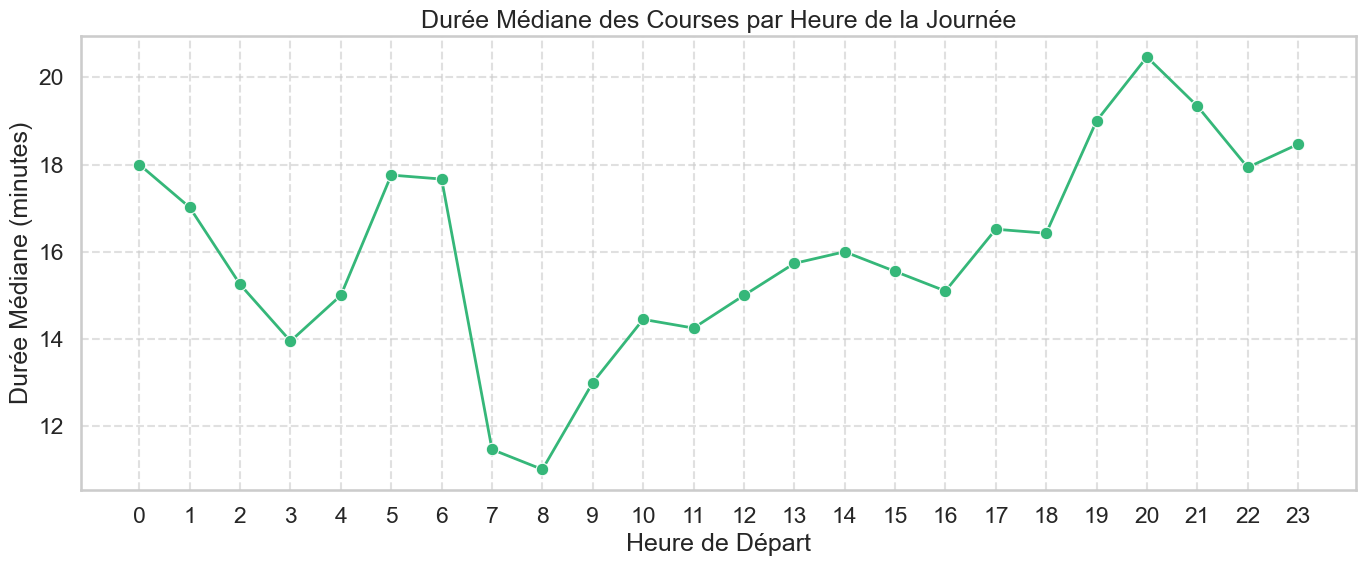

In [16]:
# %% [code]
if 'start_hour' in df.columns and 'trip_minutes' in df.columns:
    # Durée médiane par heure
    duration_by_hour = df.groupby('start_hour')['trip_minutes'].median().reset_index()

    plt.figure(figsize=(14, 6))
    sns.lineplot(data=duration_by_hour, x='start_hour', y='trip_minutes',
                 marker='o', linewidth=2, color=base_palette[5])
    plt.title("Durée Médiane des Courses par Heure de la Journée")
    plt.xlabel("Heure de Départ")
    plt.ylabel("Durée Médiane (minutes)")
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Colonnes 'start_hour' ou 'trip_minutes' non disponibles.")


IQR Clipping → trip_minutes: [0.00, 51.78]


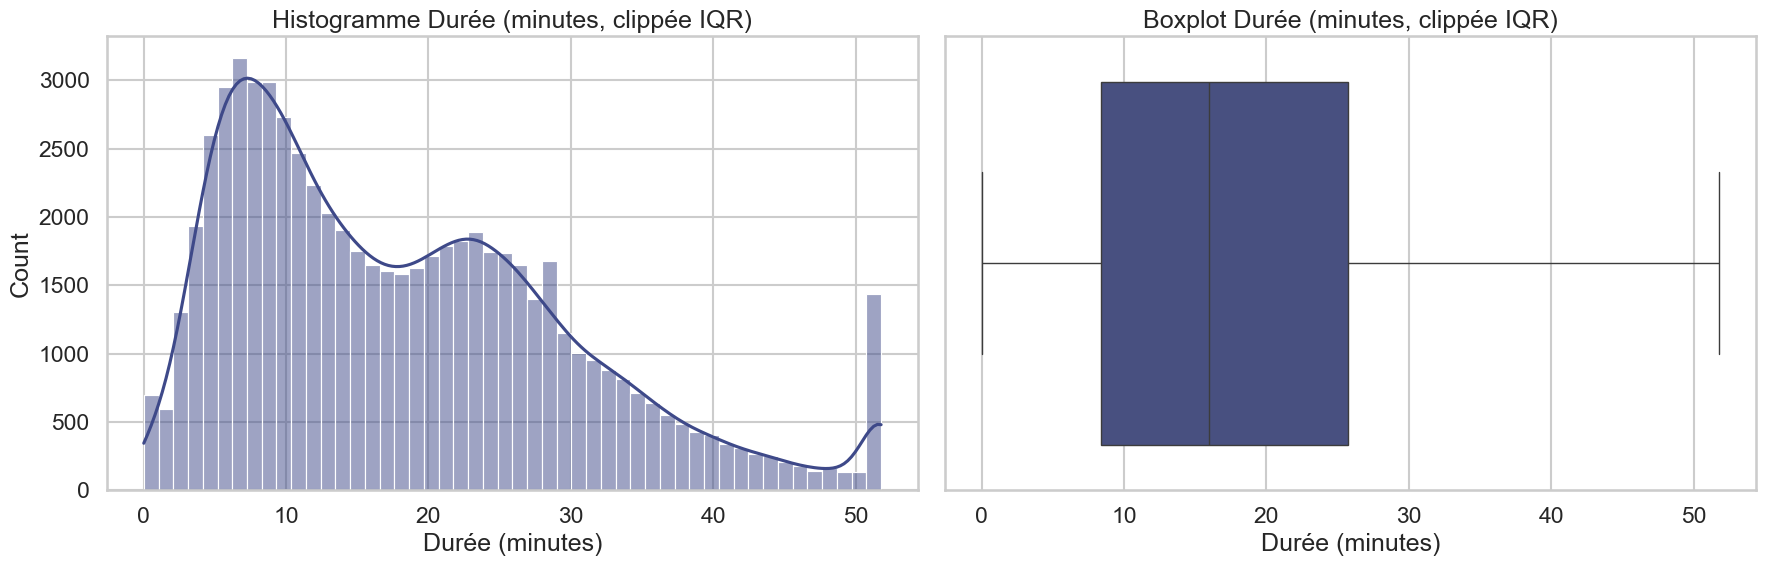

In [19]:
# %% [code]
if 'trip_minutes' in df.columns:
    df['trip_minutes_iqr_capped'] = iqr_clip(df['trip_minutes'].dropna(), verbose=True)

    # Histogramme + boxplot côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    sns.histplot(df['trip_minutes_iqr_capped'].dropna(), bins=50, kde=True, ax=axes[0], color=base_palette[1])
    axes[0].set_title("Histogramme Durée (minutes, clippée IQR)")
    axes[0].set_xlabel("Durée (minutes)")

    sns.boxplot(x=df['trip_minutes_iqr_capped'].dropna(), ax=axes[1], color=base_palette[1])
    axes[1].set_title("Boxplot Durée (minutes, clippée IQR)")
    axes[1].set_xlabel("Durée (minutes)")

    plt.tight_layout()
    plt.show()
else:
    print("Colonne 'trip_minutes' non disponible pour visualisation.")


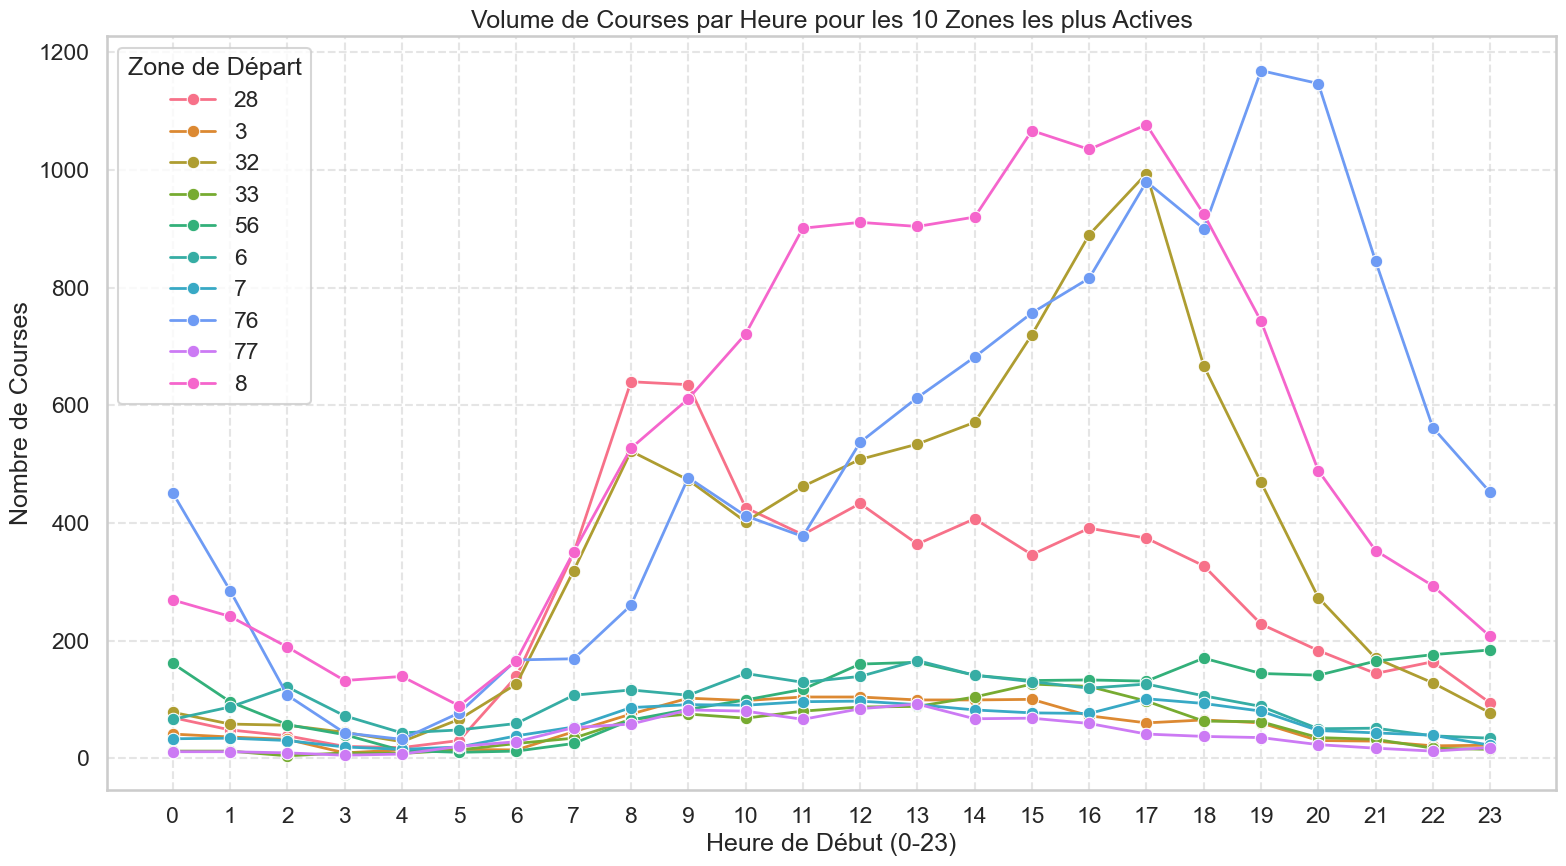

In [21]:
# %% [code]
# Vérification que les colonnes nécessaires sont présentes
if 'pickup_community_area' in df.columns and 'start_hour' in df.columns:

    # Top 10 zones les plus fréquentes
    top_zones = df['pickup_community_area'].value_counts().nlargest(10).index.tolist()
    df_top_zones = df[df['pickup_community_area'].isin(top_zones)].copy()

    # 👇 Cast obligatoire pour seaborn
    df_top_zones['pickup_community_area'] = df_top_zones['pickup_community_area'].astype(str)

    # Calcul du volume horaire pour chaque zone
    hourly_counts = (
        df_top_zones.groupby(['pickup_community_area', 'start_hour'])
        .size()
        .reset_index(name='trip_count')
    )

    # Affichage
    plt.figure(figsize=(16, 9))
    sns.lineplot(
        data=hourly_counts,
        x='start_hour',
        y='trip_count',
        hue='pickup_community_area',
        marker='o',
        linewidth=2
    )

    plt.title("Volume de Courses par Heure pour les 10 Zones les plus Actives")
    plt.xlabel("Heure de Début (0-23)")
    plt.ylabel("Nombre de Courses")
    plt.xticks(range(0, 24))
    plt.legend(title="Zone de Départ")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

else:
    print("Colonnes 'pickup_community_area' et/ou 'start_hour' manquantes.")


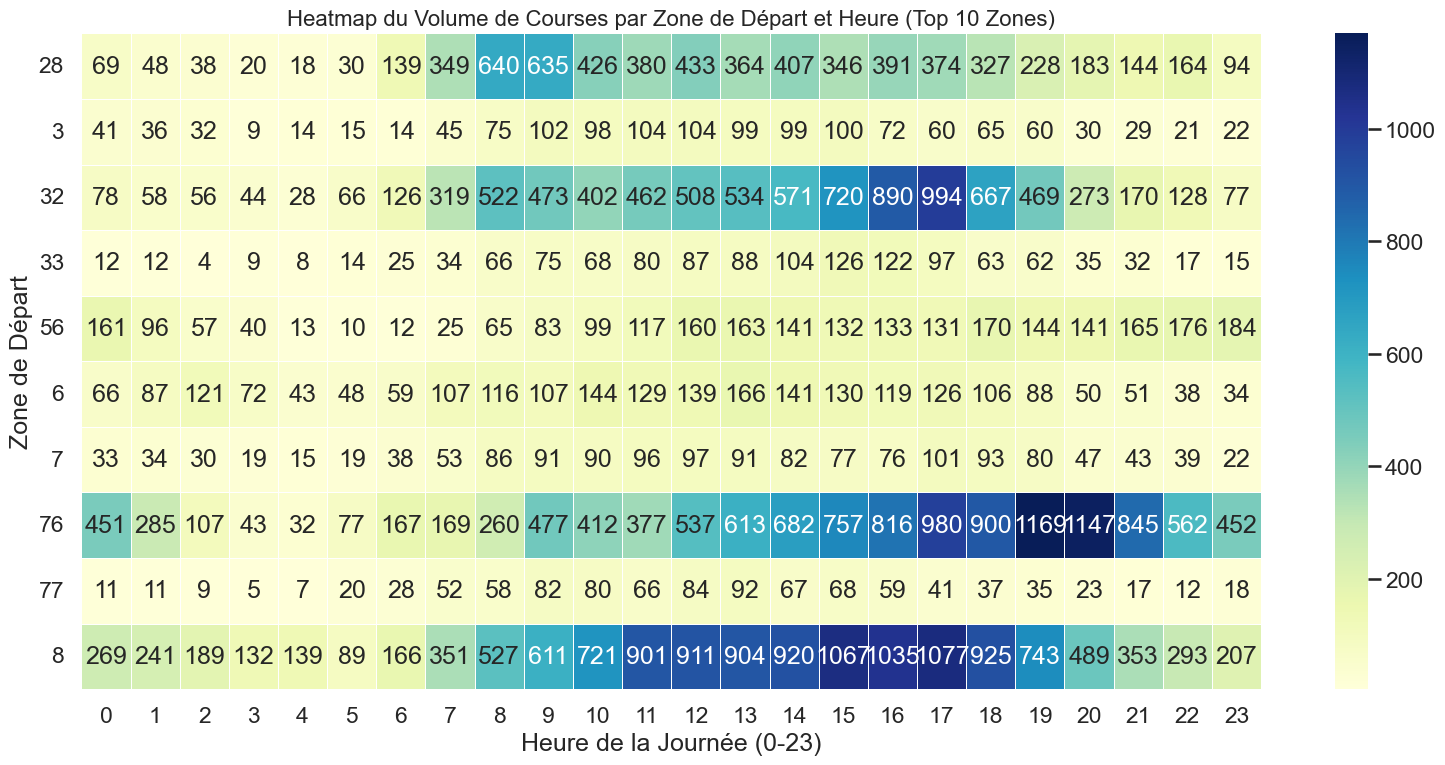

In [22]:
# %% [code]
# Vérification des colonnes nécessaires
if 'pickup_community_area' in df.columns and 'start_hour' in df.columns:

    # Préparer les données
    top_zones = df['pickup_community_area'].value_counts().nlargest(10).index.tolist()
    df_heat = df[df['pickup_community_area'].isin(top_zones)].copy()
    df_heat['pickup_community_area'] = df_heat['pickup_community_area'].astype(str)

    # Agrégation des volumes de trajets par zone et heure
    heatmap_data = (
        df_heat
        .groupby(['pickup_community_area', 'start_hour'])
        .size()
        .reset_index(name='trip_count')
        .pivot(index='pickup_community_area', columns='start_hour', values='trip_count')
        .fillna(0)
    )

    # Affichage de la heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=.5, annot=True, fmt=".0f")
    plt.title("Heatmap du Volume de Courses par Zone de Départ et Heure (Top 10 Zones)", fontsize=16)
    plt.xlabel("Heure de la Journée (0-23)")
    plt.ylabel("Zone de Départ")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Colonnes 'pickup_community_area' et/ou 'start_hour' manquantes.")
